In [1]:
#%pip install -U pretty_midi

In [1]:
#%pip install -U pretty_midi
import pretty_midi
import os
import csv
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score, f1_score,classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
#%pip install matplotlib
#%pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

from keras.models import Sequential
from keras.layers import LSTM, Dense, Masking, Conv1D, Conv2D, MaxPooling1D, Flatten
from keras.utils import to_categorical

In [2]:
data_dir = "Four_composers"

### Extract the relevant features from each MIDI file. Store the features in a list X, and the associated composer in a list y. 

In [3]:
import warnings

def extract_features(midi_file):
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning, message="Tempo, Key or Time signature change events found on non-zero tracks")
            midi_data = pretty_midi.PrettyMIDI(midi_file)
    except IOError as e:
        print(f"Error reading file {midi_file}: {str(e)}")
        return None
    except Exception as e:
        print(f"Error parsing MIDI file {midi_file}: {str(e)}")
        return None

    try:
        tempo_changes = midi_data.get_tempo_changes()
        tempo = tempo_changes[1][0] if len(tempo_changes) > 1 and len(tempo_changes[1]) > 0 else 120
    except IndexError:
        tempo = 120

    num_instruments = len(midi_data.instruments)
    
    total_velocity = 0
    total_notes = 0
    for instrument in midi_data.instruments:
        total_velocity += sum(note.velocity for note in instrument.notes)
        total_notes += len(instrument.notes)
    
    avg_velocity = total_velocity / total_notes if total_notes > 0 else 0
    
    pitch_classes = [0] * 12
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            pitch_classes[note.pitch % 12] += 1
    
    # Ignore key signature errors
    try:
        key = midi_data.key_signature_changes[0].key_number if midi_data.key_signature_changes else 0
    except (ValueError, IndexError):
        key = 0

    return [tempo, num_instruments, avg_velocity, key] + pitch_classes

X = []
y = []
error_count = 0
for composer in os.listdir(data_dir):
    composer_dir = os.path.join(data_dir, composer)
    if os.path.isdir(composer_dir):
        for root, dirs, files in os.walk(composer_dir):
            for midi_file in files:
                if midi_file.endswith('.mid'):
                    file_path = os.path.join(root, midi_file)
                    features = extract_features(file_path)
                    if features is not None:
                        X.append(features)
                        y.append(composer)
                    else:
                        error_count += 1
                        print(f"Skipping file {file_path} due to errors")

if error_count == 0:
    print("No errors found in dataset.")

No errors found in dataset.


In [4]:
X_np = np.array(X)
y_np = np.array(y)

In [5]:
len(y)

1527

In [6]:
X_np.shape

(1527, 16)

In [7]:
X_np

array([[1.16000085e+02, 8.00000000e+00, 7.72308461e+01, ...,
        1.44000000e+02, 1.41300000e+03, 3.80000000e+01],
       [6.49999946e+01, 1.30000000e+01, 5.25016968e+01, ...,
        3.93000000e+02, 3.44000000e+02, 1.27000000e+02],
       [2.34000234e+02, 8.00000000e+00, 1.05596102e+02, ...,
        2.28100000e+03, 5.90000000e+01, 6.39000000e+02],
       ...,
       [7.60000659e+01, 8.00000000e+00, 1.00000000e+02, ...,
        2.02000000e+02, 1.44000000e+02, 4.24000000e+02],
       [9.00000900e+01, 1.00000000e+01, 7.96183372e+01, ...,
        7.22000000e+02, 9.92000000e+02, 5.40000000e+01],
       [7.60000659e+01, 9.00000000e+00, 8.30230348e+01, ...,
        5.65000000e+02, 1.00000000e+00, 4.39000000e+02]])

### Convert X into an array. Perform train-test split.

In [8]:
X = np.array(X)
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2)

### Standard Scaling on X_train and X_test.

In [9]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### SMOTE resampling on the training sets

In [10]:
#%pip install -U -q imbalanced-learn
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_scaled_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

### Visualize the data imbalance, and correction after SMOTE.

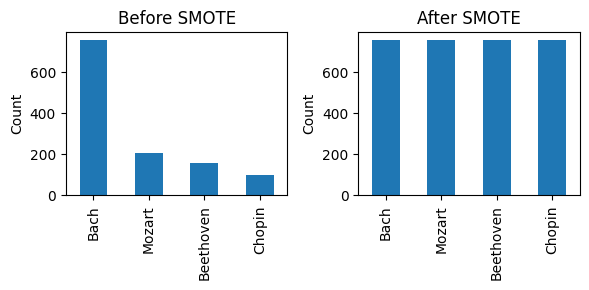

In [11]:
# Convert y_train and y_train_smote to pandas Series
y_train_series = pd.Series(y_train)
y_train_smote_series = pd.Series(y_train_smote)

f = plt.figure(figsize=(6, 3))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# Plot before SMOTE
ax1 = f.add_subplot(1, 2, 1)
y_train_series.value_counts().plot(kind='bar', ax=ax1)
ax1.set_title("Before SMOTE")
ax1.set_ylabel("Count")

# Plot after SMOTE
ax2 = f.add_subplot(1, 2, 2)
y_train_smote_series.value_counts().plot(kind='bar', ax=ax2)
ax2.set_title("After SMOTE")
ax2.set_ylabel("Count")

plt.tight_layout()
plt.show()

### SVM

In [ ]:
# Train a Support Vector Machine classifier
svm_clf = SVC(kernel='rbf', gamma=0.4, degree=5, C=18.0, decision_function_shape='ovr')
svm_clf.fit(X_train_scaled_smote, y_train_smote)

### LSTM

In [12]:
y_train.shape

(1221,)

In [13]:
X_train.shape

(1221, 16)

In [14]:
X_train = np.reshape(X_train, (-1,X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (-1,X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Build the model
model = Sequential()
model.add(LSTM(50, batch_input_shape=(X_train.shape[0],X_train.shape[1],1)))
model.add(Dense(25, activation='relu'))
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(X_train_scaled_smote, y_train_scaled, epochs=20, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

### CNN

In [17]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
y_train_encoded = LE.fit_transform(y_train_smote)
y_test_encoded = LE.transform(y_test)

from tensorflow.keras.utils import to_categorical
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

In [21]:
from keras import Sequential 
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

num_classes = len(np.unique(y_train_smote))
X_train_reshaped = X_train_scaled_smote.reshape((X_train_scaled_smote.shape[0], X_train_scaled_smote.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

input_shape = (X_train_scaled_smote.shape[1], 1)

# Build the model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_scaled_smote, y_train_categorical, epochs=20, batch_size=16)

loss, accuracy = model.evaluate(X_test_reshaped, y_test_categorical)
print(f'Test Accuracy: {accuracy}')

Epoch 1/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5424 - loss: 1.1257
Epoch 2/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.6807 - loss: 0.7799
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.7386 - loss: 0.6418
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.7944 - loss: 0.5408
Epoch 5/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.8086 - loss: 0.5074
Epoch 6/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - accuracy: 0.8346 - loss: 0.4436
Epoch 7/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.8346 - loss: 0.4280
Epoch 8/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.8742 - loss: 0.3607
Epoch 9/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.8784 - loss: 0.3258
Epoch 10/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.8748 - loss: 0.3161
Epoch 11/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.8908 - loss: 0.3002
Epoch 12/20
189/189 ━━━━━━━━━━━━

In [22]:
y_pred = model.predict(X_test_reshaped)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [24]:
# Convert y_pred from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_test_categorical back to class labels
y_test_classes = np.argmax(y_test_categorical, axis=1)

# Generate the classification report
report = classification_report(y_test_classes, y_pred_classes, zero_division=1)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       169
           1       0.59      0.80      0.68        51
           2       0.82      0.59      0.69        39
           3       0.53      0.49      0.51        47

    accuracy                           0.78       306
   macro avg       0.72      0.70      0.70       306
weighted avg       0.79      0.78      0.78       306



### Train model using radial basis vector kernel.

In [10]:
y_pred = svm_clf.predict(X_test_scaled)
rbf_accuracy = accuracy_score(y_test, y_pred)
rbf_f1 = f1_score(y_test, y_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (RBF Kernel):  77.78
F1 (RBF Kernel):  78.17


In [11]:
# Generate and print the classification report
report = classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

        Bach       0.92      0.90      0.91       189
   Beethoven       0.43      0.62      0.51        37
      Chopin       0.64      0.64      0.64        22
      Mozart       0.68      0.52      0.59        58

    accuracy                           0.78       306
   macro avg       0.67      0.67      0.66       306
weighted avg       0.79      0.78      0.78       306



### Print confusion matrix.

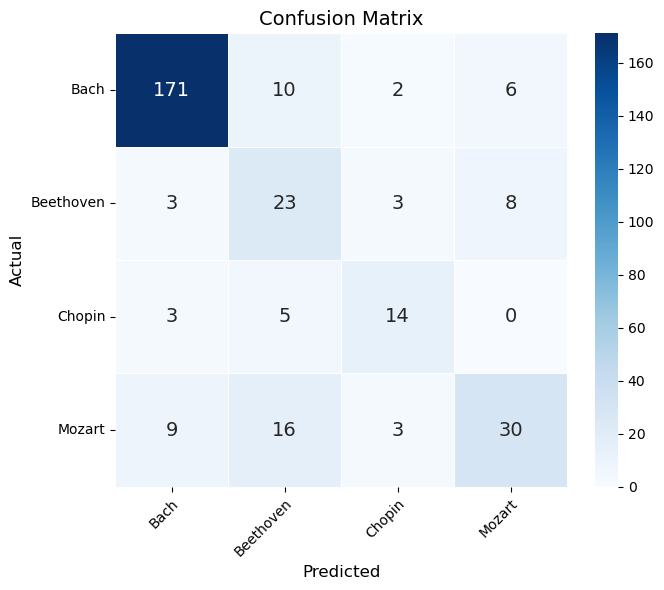

In [12]:
labels = sorted(set(y_test) | set(y_pred))

cmatrix = confusion_matrix(y_test, y_pred, labels=labels)
fontsize = 7
figsize = (7, 6)  # Increased figure size for better readability
cmap = plt.colormaps.get_cmap("Blues")
fig, ax = plt.subplots(figsize=figsize)

sns.heatmap(cmatrix, 
            annot=True, 
            cmap=cmap, 
            cbar=True, 
            ax=ax, 
            linewidths=0.5,
            fmt='d',
            annot_kws={'fontsize': 14},
            xticklabels=labels,
            yticklabels=labels)

plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right")

plt.tight_layout()
plt.show()